# Загрузка библиотек

In [1]:
import os
import gc
import numpy as np
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка даннык с kaggle

In [2]:
path = kagglehub.dataset_download('jehanbhathena/weather-dataset')
print('Путь к папке датасета', path)

data = list()

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        label = dirname.split('/')[-1]
        image = os.path.join(dirname, filename)
        data.append((label, image))

df = pd.DataFrame(data, columns=['label', 'image'])
df.head()

100%|██████████| 587M/587M [00:02<00:00, 259MB/s]

Extracting files...


Путь к папке датасета /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3


,label,image
0,rainbow,/root/.cache/kagglehub/datasets/jehanbhathena/...
1,rainbow,/root/.cache/kagglehub/datasets/jehanbhathena/...
2,rainbow,/root/.cache/kagglehub/datasets/jehanbhathena/...
3,rainbow,/root/.cache/kagglehub/datasets/jehanbhathena/...
4,rainbow,/root/.cache/kagglehub/datasets/jehanbhathena/...


# Информация о полученных данных

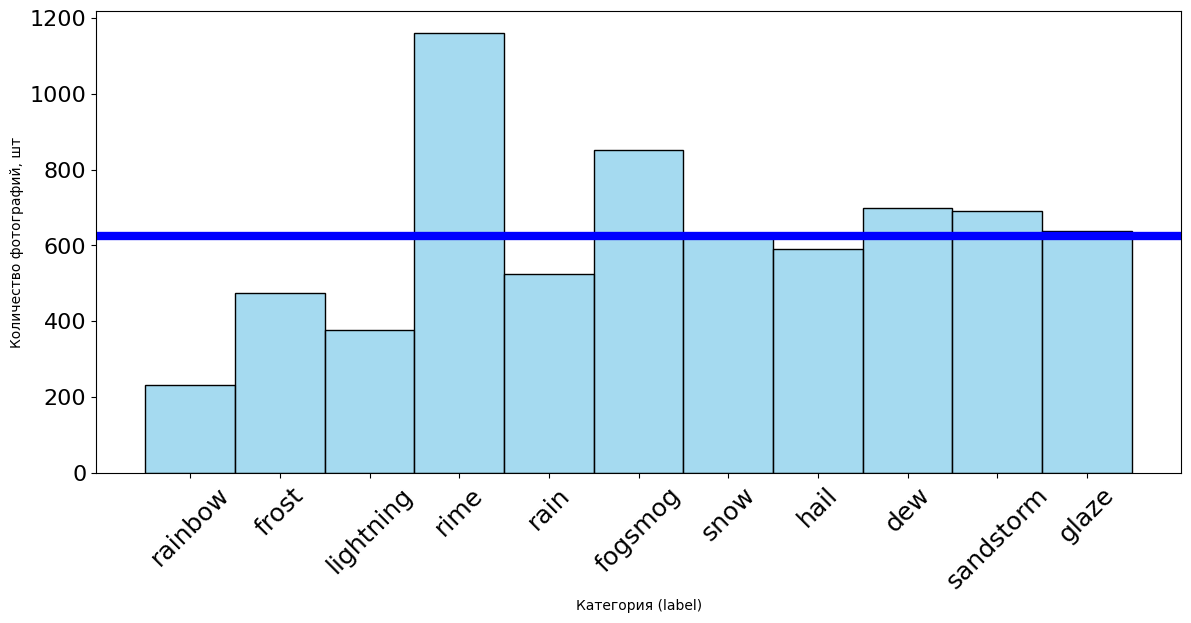

Распределение классов: 
 Counter({'rime': 1160, 'fogsmog': 851, 'dew': 698, 'sandstorm': 692, 'glaze': 639, 'snow': 621, 'hail': 591, 'rain': 526, 'frost': 475, 'lightning': 377, 'rainbow': 232})


In [3]:
ax = sns.histplot(data=df, x='label', color='skyblue')
ax.figure.set_size_inches(14, 6)
plt.axhline(y=df.groupby('label').count().mean().mean(), lw=6, color='blue')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=16)
ax.set_ylabel('Количество фотографий, шт')
ax.set_xlabel('Категория (label)')

plt.show()

class_counts = Counter(df['label'])
print('Распределение классов: \n', class_counts)

# Вывод примеров фотографий

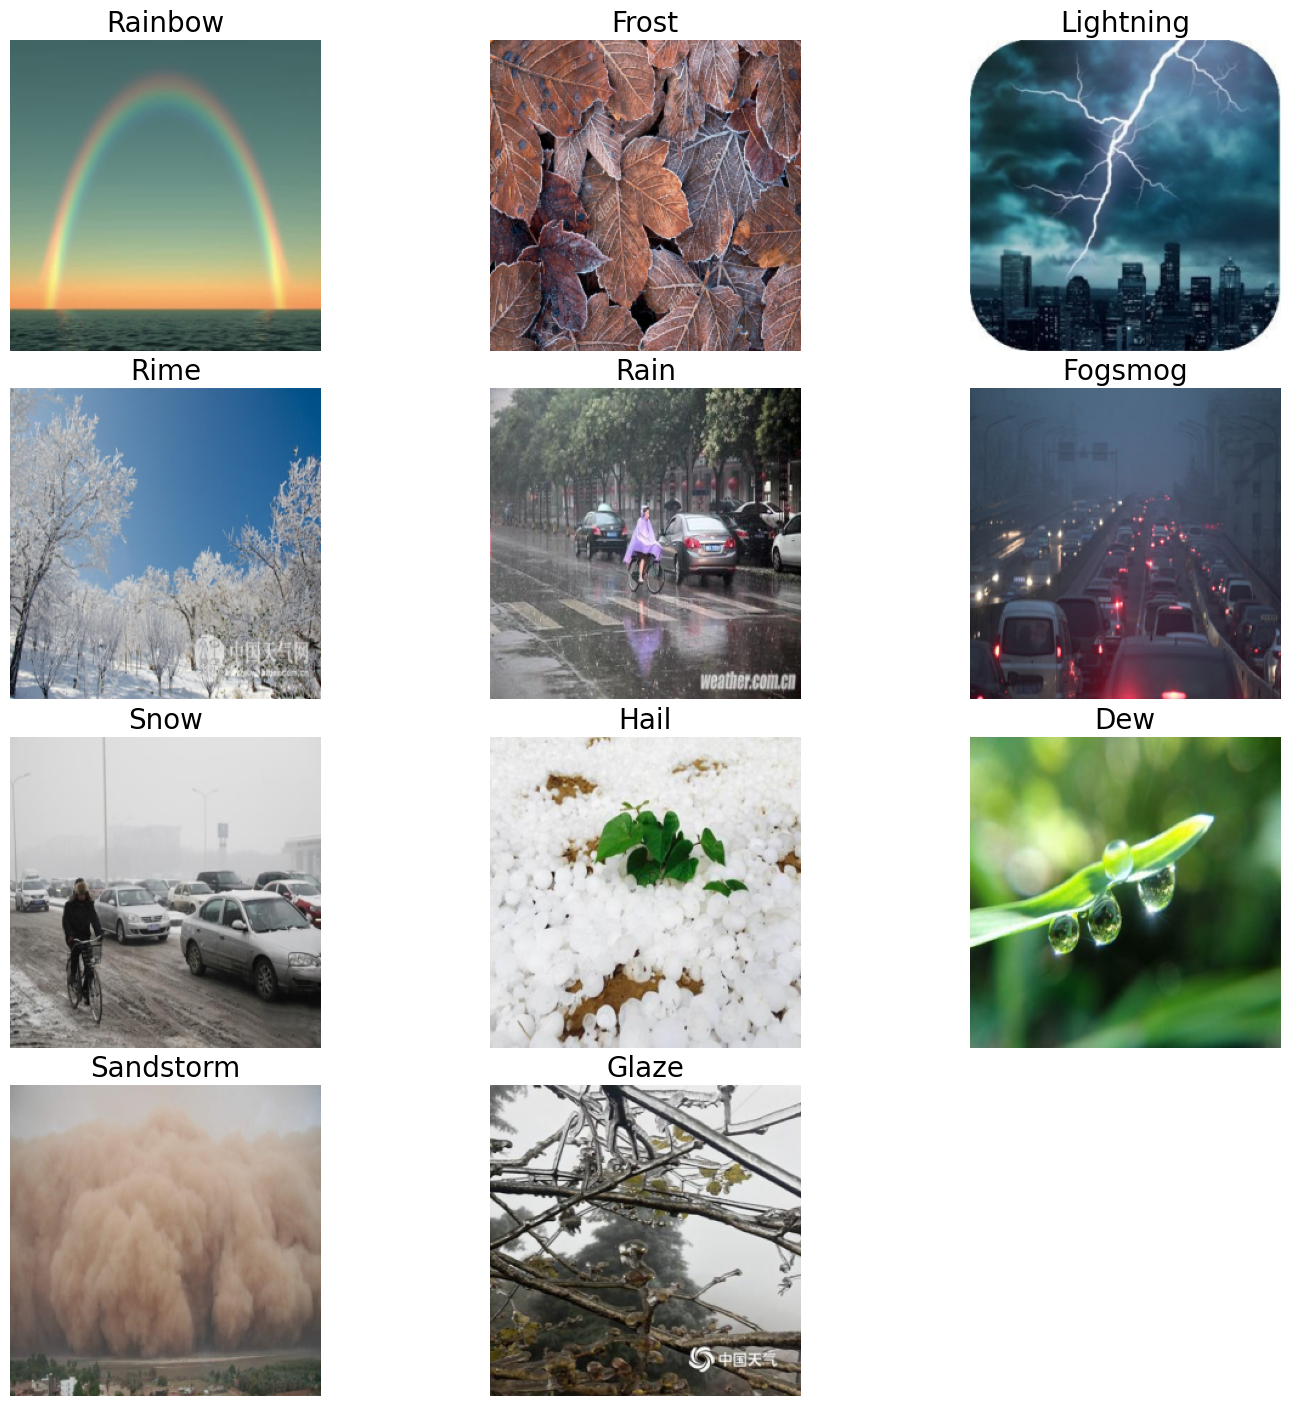

In [4]:
examples = pd.DataFrame([])
unique_labels = df['label'].unique()
for label in unique_labels:
    examples = pd.concat([examples, df.query(f"label == '{label}'").sample(1)])

fig = plt.figure(figsize=(15, 14))
for index, row in examples.reset_index().iterrows():
    ax = plt.subplot(4, 3, index + 1)
    image = cv2.imread(row['image'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    ax.set_title(row['label'].title(), fontsize=20)
    ax.axis('off')

fig.tight_layout(pad=0.5)
plt.show()

# Предобработка данных

### Предобработка фотографий и создание тензоров

In [5]:
def process_image(img):
    try:
        pic = cv2.imread(img)
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
        pic = cv2.resize(pic, (256, 256), interpolation=cv2.INTER_AREA)
        pic = np.array(pic, dtype=np.float32)
        return pic
    except:
        return np.zeros(shape=(256, 256, 3), dtype=np.float32)

list_of_paths = df['image'].to_numpy()
images = [process_image(path) for path in list_of_paths]
images = np.array(images, dtype=np.float32)
images.shape

(6862, 256, 256, 3)

### Предобработка labels

In [6]:
def convert_categorical_to_number(label):
    return unique_labels.index(label)

unique_labels = list(unique_labels)
labels = df['label'].to_numpy()
func = np.vectorize(convert_categorical_to_number)
labels = func(labels)
labels

array([ 0,  0,  0, ..., 10, 10, 10])

In [ ]:
# Теперь выводим соответствие метки и числа
label_to_number_mapping = {label: convert_categorical_to_number(label) for label in unique_labels}
print(label_to_number_mapping)

{'rainbow': 0, 'frost': 1, 'lightning': 2, 'rime': 3, 'rain': 4, 'fogsmog': 5, 'snow': 6, 'hail': 7, 'dew': 8, 'sandstorm': 9, 'glaze': 10}


### Разделение датасета

In [ ]:
# - 80% для обучения (images_train, labels_train)
# - 10% для валидации (images_val, labels_val)
# - 10% для тестирования (images_test, labels_test)
images_train, images_test_and_val, labels_train, labels_test_and_val = train_test_split(images, labels, test_size=0.2,  random_state=42)
images_val, images_test, labels_val, labels_test = train_test_split(images, labels, test_size=0.5,  random_state=42)

In [ ]:
# удаляем ненужное
del images
gc.collect()

145

# Создание модели

In [9]:
# Преобразование меток в формат one-hot
num_classes = 11  # Количество категорий
labels_train = to_categorical(labels_train, num_classes)
labels_val = to_categorical(labels_val, num_classes)
labels_test = to_categorical(labels_test, num_classes)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Остановиться после 3 эпох без улучшения
    restore_best_weights=True
)

def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule)


def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        # layers.Flatten(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (256, 256, 3)  # Размер входных данных
model = create_model(input_shape, 11)
model.summary()

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(images_train, labels_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(images_val, labels_val),
                    callbacks=[early_stopping, lr_scheduler])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 global_average_pooling2d (  (None, 64)                0

In [11]:
test_loss, test_accuracy = model.evaluate(images_test, labels_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


108/108 [==============================] - 76s 697ms/step - loss: 0.6973 - accuracy: 0.7756
Test Accuracy: 77.56%


In [12]:

model.save("small_model.h5")
model = load_model("small_model.h5")


# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()


# with open("small_model_quantized.tflite", "wb") as f:
#     f.write(tflite_model)
# print("Модель успешно сжата и сохранена!")

def representative_data_gen():
    for image in images_train[:100]:  # Используем небольшую выборку для анализа
        yield [np.expand_dims(image, axis=0)]


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Указываем квантизацию активаций и весов
converter.representative_dataset = representative_data_gen  # Функция для данных
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model_quant = converter.convert()

# Сохраняем квантизированную модель
with open("model_full_quantized.tflite", "wb") as f:
    f.write(tflite_model_quant)
print("Полностью квантизированная модель создана!")



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Полностью квантизированная модель создана!


In [13]:
interpreter = tf.lite.Interpreter(model_path="model_full_quantized.tflite")
interpreter.allocate_tensors()

# Получение информации о модели
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Model Size (KB):", os.path.getsize("model_full_quantized.tflite") / 1024)


Input Shape: [  1 256 256   3]
Model Size (KB): 73.96875
